In [1]:
import tensorflow as tf
import numpy as np
import input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

/home/chahuja/env/tf/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
## Visualizing reconstructions
def vis(images, save_name):
    dim = images.shape[0]
    n_image_rows = int(np.ceil(np.sqrt(dim)))
    n_image_cols = int(np.ceil(dim * 1.0/n_image_rows))
    gs = gridspec.GridSpec(n_image_rows,n_image_cols,top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)
    for g,count in zip(gs,range(int(dim))):
        ax = plt.subplot(g)
        ax.imshow(images[count,:].reshape((28,28)))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig(save_name + '_vis.png')

In [3]:
mnist_width = 28
n_visible = mnist_width * mnist_width
n_hidden = 500
corruption_level = 0.3

# create node for input data
X = tf.placeholder("float", [None, n_visible], name='X')

# create node for corruption mask
mask = tf.placeholder("float", [None, n_visible], name='mask')

# create nodes for hidden variables
W_init_max = 4 * np.sqrt(6. / (n_visible + n_hidden))
W_init = tf.random_uniform(shape=[n_visible, n_hidden],
                           minval=-W_init_max,
                           maxval=W_init_max)

W = tf.Variable(W_init, name='W')
b = tf.Variable(tf.zeros([n_hidden]), name='b')

W_prime = tf.transpose(W)  # tied weights between encoder and decoder
b_prime = tf.Variable(tf.zeros([n_visible]), name='b_prime')


def model(X, mask, W, b, W_prime, b_prime):
    tilde_X = mask * X  # corrupted X

    Y = tf.nn.sigmoid(tf.matmul(tilde_X, W) + b)  # hidden state
    Z = tf.nn.sigmoid(tf.matmul(Y, W_prime) + b_prime)  # reconstructed input
    return Z

# build model graph
Z = model(X, mask, W, b, W_prime, b_prime)

# create cost function
cost = tf.reduce_sum(tf.pow(X - Z, 2))  # minimize squared error
train_op = tf.train.GradientDescentOptimizer(0.02).minimize(cost)  # construct an optimizer
predict_op = Z
# load MNIST data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

('Extracting', 'MNIST_data/train-images-idx3-ubyte.gz')
('Extracting', 'MNIST_data/train-labels-idx1-ubyte.gz')
('Extracting', 'MNIST_data/t10k-images-idx3-ubyte.gz')
('Extracting', 'MNIST_data/t10k-labels-idx1-ubyte.gz')


/usr/lib/python2.7/gzip.py:268: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  chunk = self.extrabuf[offset: offset + size]
input_data.py:42: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  data = data.reshape(num_images, rows, cols, 1)


In [4]:
# Launch the graph in a session
with tf.Session() as sess:
    # you need to initialize all variables
    tf.initialize_all_variables().run()

    for i in range(100):
        for start, end in zip(range(0, len(trX), 128), range(128, len(trX)+1, 128)):
            input_ = trX[start:end]
            mask_np = np.random.binomial(1, 1 - corruption_level, input_.shape)
            sess.run(train_op, feed_dict={X: input_, mask: mask_np})

        mask_np = np.random.binomial(1, 1 - corruption_level, teX.shape)
        print(i, sess.run(cost, feed_dict={X: teX, mask: mask_np}))
    # save the predictions for 100 images
    mask_np = np.random.binomial(1, 1 - corruption_level, teX[:100].shape)
    predicted_imgs = sess.run(predict_op, feed_dict={X: teX[:100], mask: mask_np})
    input_imgs = teX[:100]

(0, 115686.88)
(1, 99104.484)
(2, 86967.523)
(3, 84387.414)
(4, 78763.398)
(5, 74682.281)
(6, 73738.227)
(7, 71838.609)
(8, 70722.336)
(9, 70323.102)
(10, 68159.516)
(11, 66726.031)
(12, 66081.688)
(13, 65809.328)
(14, 65472.285)
(15, 64375.957)
(16, 63642.367)
(17, 65107.633)
(18, 63584.074)
(19, 63773.875)
(20, 62798.344)
(21, 63071.773)
(22, 62177.824)
(23, 61908.559)
(24, 62139.734)
(25, 62975.945)
(26, 61576.781)
(27, 60868.812)
(28, 60575.844)
(29, 61920.848)
(30, 60720.852)
(31, 60997.258)
(32, 59846.898)
(33, 59894.355)
(34, 60538.113)
(35, 59142.664)
(36, 59454.414)
(37, 59817.496)
(38, 59166.953)
(39, 60032.145)
(40, 60210.926)
(41, 58892.934)
(42, 59512.543)
(43, 59420.055)
(44, 59004.055)
(45, 58587.051)
(46, 58453.984)
(47, 58969.984)
(48, 58596.609)
(49, 58395.055)
(50, 58075.32)
(51, 58889.262)
(52, 57601.852)
(53, 58867.609)
(54, 58409.855)
(55, 57723.574)
(56, 58845.438)
(57, 57811.781)
(58, 58190.09)
(59, 58118.277)
(60, 57574.543)
(61, 57848.438)
(62, 57719.598)
(63,

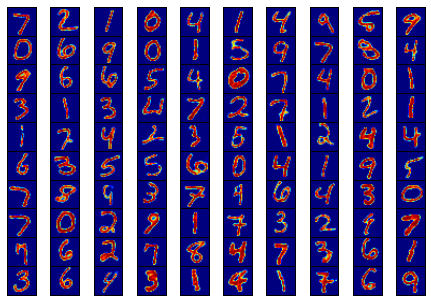

In [5]:
# Plot the reconstructed images
vis(predicted_imgs,'pred')

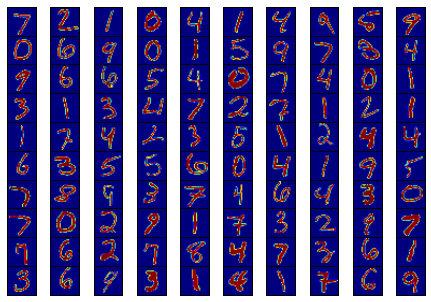

In [6]:
# Plot input images to compare with
vis(input_imgs,'in')